# Exploratory Data Analysis

*Author: Koki Sasagawa*  
*Date: 4/11/2019*

This notebook aims to study the data on a deeper level for the following reasons:

Currently, we are averaging speed across **ALL vehicles** by **hour**. 
Census regions are broad - each contain multiple routes and vehicle types that drive through over a given month. 

We can expect different vehicle types to have different speeds (i.e., bus system vs cable cars), thus, removing drastically different vehicle types may improve the predictive model. 

The current data is the entire time series speed data of **all vehicle types** belonging to a specific **region** for a given month
- Do speeds vary significantly by vehicle type?
    - We see that certain vehicles have consistent speed readings over the duration of the month - drive through only once? 
- What do the 0 readings mean?  S(i.e., vehicle pausing, parking, etc) 
- What is the **rule** for recording speeds? (Change in speed? distance? time?) - some vehicles only appear once in a months span for a region 
- The time of recording is inconsistent. No real pattern as time jumps from minute, 2 min, to hour. 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
import re
import sys

In [2]:
input_dir = '../../raw_data/'

data_files = os.listdir(input_dir)
for i, j in enumerate(data_files):
    print(i, j)        

0 Speed Limits.zip
1 .DS_Store
2 google_transit.zip
3 streets.json
4 speed_limits
5 revenue_equipment_list.csv
6 google_transit
7 tweets
8 sf_speed_data
9 TransportationTerminology.pdf
10 speed_limit_sf.json
11 census_zones


## 1. Load data

One of the SFMTA data manager shared with us the table that decodes the VEHICLE_TAG. Use this to see if there are any significant changes in speed by vehicle type.

In [5]:
# Load vehicle types
vehicle_types = pd.read_csv(input_dir + data_files[5], usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1689, 2)
Number of unqiue v-types: 65


,EQUIP_CODE,EQUIP_NAME
0,4658,40' FLYER COACH
1,4662,40' FLYER COACH
2,7053,ARTICULATED FLYER
3,1548,LRV3-MOD11
4,17,POWELL STREET CAR


In [6]:
sum(vehicle_types['EQUIP_CODE'].value_counts()) # 1689 Unique Vehicle codes

1689

In [7]:
# Remove trailing white space from column values
def remove_whitespace(entry):
    return entry.strip()

In [8]:
vehicle_types.loc[:,'EQUIP_CODE'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_CODE']), axis=1)
vehicle_types.loc[:,'EQUIP_NAME'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_NAME']), axis=1)

In [9]:
vehicle_types['EQUIP_CODE'].nunique()

1689

In [10]:
vehicle_map = {}

for i, v in vehicle_types.values:
    vehicle_map[i] = v
    
print(len(vehicle_map))

1689


In [11]:
# Monthly speed data by region
input_dir = '../../temp_data/region_data/'
print('Number of region files: {}'.format(len(os.listdir(input_dir))))
files = os.listdir(input_dir)

Number of region files: 196


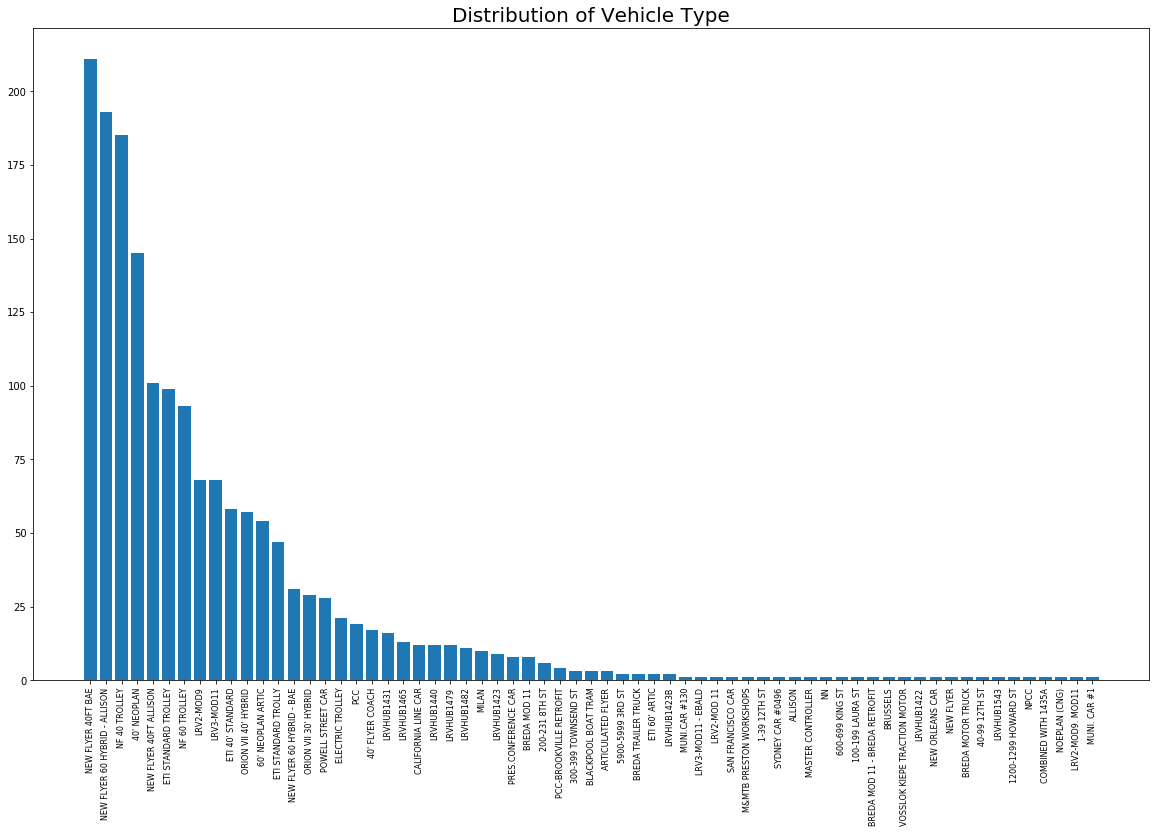

In [35]:
x = vehicle_types['EQUIP_NAME'].value_counts().index
y = vehicle_types['EQUIP_NAME'].value_counts().values

plt.figure(1, figsize=(20,12))
plt.bar(x, y)
plt.title("Distribution of Vehicle Type", fontsize=20)
plt.xticks(rotation=90, fontsize=8)
fig = plt.gcf()
fig.savefig('../../images/vehicle_types.pdf')
plt.show()

In [11]:
vehicle_types.groupby('EQUIP_NAME').head(1689).to_csv('../../temp_data/code_by_vehicle_name.csv', index=False)

Analyzing the table generated above, we can see that certain vehicle types occupy a range of numbers used as the identifying code.

## 2. Map Vehicle type to one dataset

In [14]:
sample_df = pd.read_csv(input_dir + files[1])
print("Dimensions: {}".format(sample_df.shape))
print('Unique keys: {}'.format(sample_df['VEHICLE_TAG'].nunique()))
sample_df.head()

Dimensions: (160405, 9)
Unique keys: 505


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10
0,1513,2016-02-01 06:51:43,5403,-122.43606,37.79961,3.056,POINT (-122.43606 37.79960999999999),21,6075012800
1,1513,2016-02-01 08:59:05,5403,-122.43570,37.79811,2.500,POINT (-122.4357 37.79811),21,6075012800
2,1513,2016-02-01 09:00:35,5403,-122.43717,37.79680,1.944,POINT (-122.43717 37.7968),21,6075012800
3,1513,2016-02-01 11:18:21,5403,-122.43706,37.79635,6.111,POINT (-122.43706 37.79635),21,6075012800
4,1513,2016-02-01 13:04:39,5403,-122.43720,37.79650,4.444,POINT (-122.4372 37.7965),21,6075012800


In [15]:
sample_df['VEHICLE_NAME'] = sample_df['VEHICLE_TAG'].map(vehicle_map)
print('Unique vehicle names: {}'.format(sample_df['VEHICLE_NAME'].nunique()))

Unique vehicle names: 10


Clearly, not all vehicle tags mapped successfully. Check to see how many tags did not match to the vehicle type table

In [16]:
print("Non mapping vehicle tags: {}".format(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].nunique()))
print(sorted(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].unique()))

Non mapping vehicle tags: 84
['5401', '5402', '5403', '5406', '5411', '5412', '5418', '5423', '5426', '5427', '5431', '5434', '5439', '5459', '5464', '5468', '5481', '5488', '5507', '5511', '5512', '5516', '5522', '5531', '5532', '5537', '5564', '5591', '5602', '5620', '5623', '5636', '5640', '6204', '8001', '8004', '8009', '8011', '8014', '8015', '8017', '8024', '8026', '8027', '8032', '8042', '8104', '8111', '8112', '8122', '8137', '8139', '8140', '8147', '8179', '8187', '8190', '8191', '8204', '8213', '8219', '8220', '8226', '8228', '8229', '8235', '8309', '8311', '8315', '8335', '8340', '8343', '8348', '8350', '8355', '8357', '8358', '8359', '8360', '8366', 'T043', 'T280', 'T283', 'T286']


In [17]:
sample_df.isna().sum()

REV                 0
REPORT_TIME         0
VEHICLE_TAG         0
LONGITUDE           0
LATITUDE            0
SPEED               0
geometry            0
index_right         0
geoid10             0
VEHICLE_NAME    26494
dtype: int64

In [20]:
print("{:1.2f}% of values missing".format((26494 / sample_df.shape[0])*100))

16.52% of values missing


84 vehicle tags did not map to a vehicle name.

Further analyzing the vehicle types key, we see that vehicle id's tend to correspond to certain number ranges. For example, the numbers ranging from 4500 - 4700 all are vehicle type 40' FLYER COACH. Another strong grouping is the 5000 - 5350 range, which correspond to ELECTRIC TROLLEY.

For now, we will simply keep the values that did not map to a vehicle type. Instead, with the entries that mapped to a specific vehicle type, we will analyze the distribution of their speed. 

Note: Although the patterns appear strong enough, this is still an assumption we are making with the dataset. In the future, a cleaner dataset can prevent issues such as this. 

<Figure size 432x288 with 0 Axes>

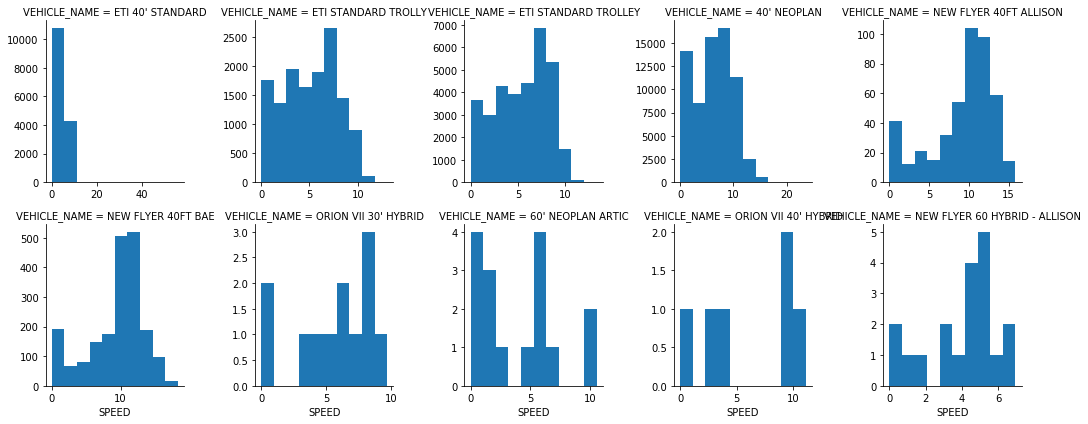

In [23]:
# 6075012800 - 1
plt.figure(2)
g = sns.FacetGrid(sample_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(plt.hist, "SPEED")
g.savefig('../../output/region6075012800.pdf')
plt.show()

## 2. Observe Distribution of Vehicle Speed by Vehicle type for all monthly data (feb 2016)

In [24]:
main_df = pd.read_csv(input_dir + files[0], usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float,
                                                                                     'VEHICLE_TAG': str})
size = []
size.append(main_df.shape[0])

for i in files[1:]:
    sample_df = pd.read_csv(input_dir + i, usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float,
                                                                                    'VEHICLE_TAG': str})
    size.append(sample_df.shape[0])
    main_df = pd.concat([main_df, sample_df], axis=0, ignore_index=True)
    
print("Total number of rows combined: {}".format(sum(size)))

Total number of rows combined: 33350866


In [25]:
main_df.columns = ['KEY', 'SPEED']
print(main_df.dtypes)
print("Dimensions: {}".format(main_df.shape))
print('Unique keys: {}'.format(main_df['KEY'].nunique()))
main_df.head()

KEY       object
SPEED    float64
dtype: object
Dimensions: (33350866, 2)
Unique keys: 1261


,KEY,SPEED
0,5486,0.000
1,5486,0.000
2,5486,3.056
3,5494,10.556
4,5494,10.278


In [26]:
# Check sparsity of data
main_df.isna().sum()

KEY      0
SPEED    0
dtype: int64

In [27]:
# Map vehicle type to key
main_df['VEHICLE_NAME'] = main_df['KEY'].map(vehicle_map)
print("Dimensions: {}".format(main_df.shape))
print("Unique vehicle names: {}".format(main_df['VEHICLE_NAME'].nunique()))
main_df.head()

Dimensions: (33350866, 3)
Unique vehicle names: 28


,KEY,SPEED,VEHICLE_NAME
0,5486,0.000,ETI STANDARD TROLLY
1,5486,0.000,ETI STANDARD TROLLY
2,5486,3.056,ETI STANDARD TROLLY
3,5494,10.556,ETI STANDARD TROLLY
4,5494,10.278,ETI STANDARD TROLLY


In [28]:
main_df.isna().sum()

KEY                   0
SPEED                 0
VEHICLE_NAME    5113481
dtype: int64

In [31]:
print("{:1.2f}% of values missing".format((main_df.isna().sum().values[-1] / main_df.shape[0])*100))

15.33% of values missing


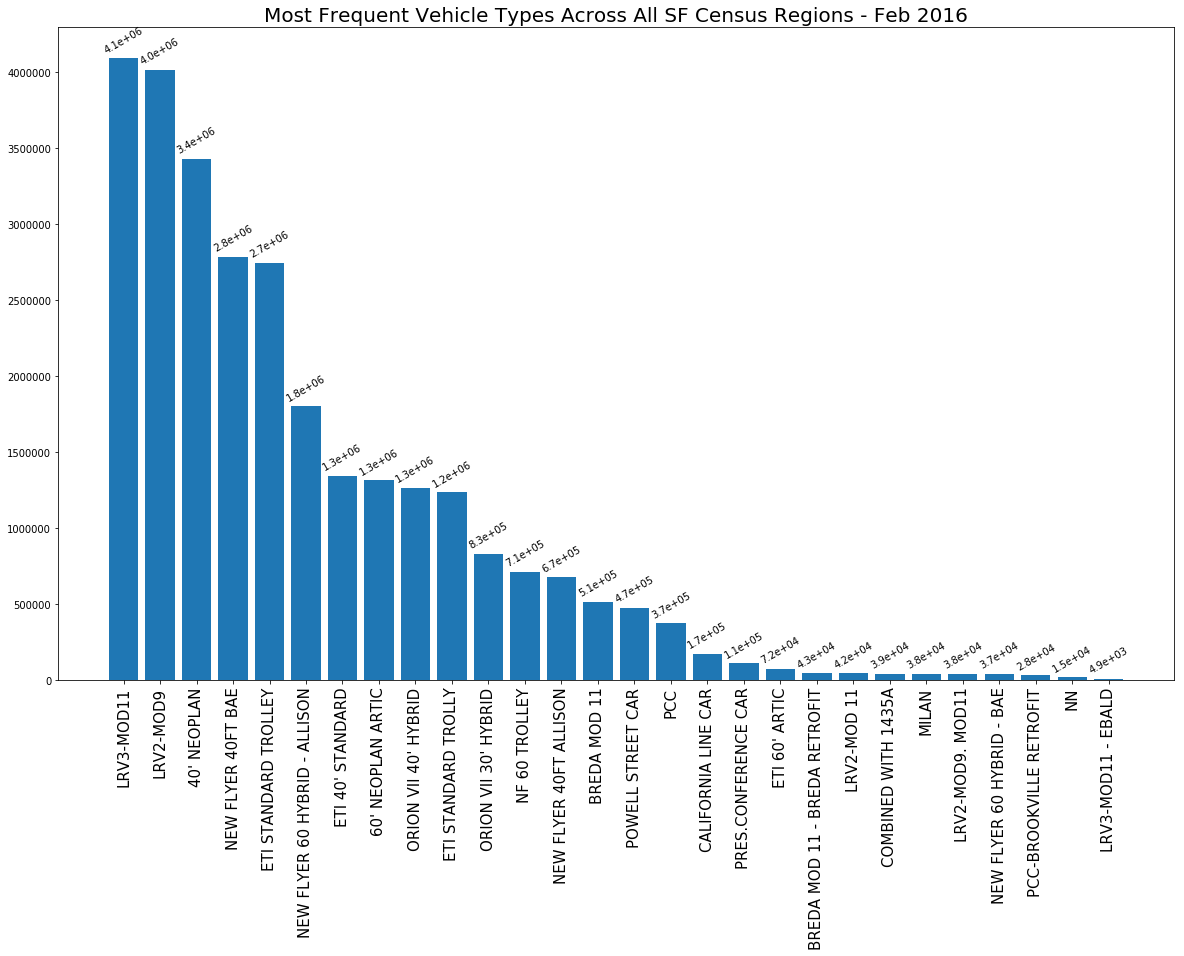

In [64]:
# See the number of times a vehicle appears
x = main_df['VEHICLE_NAME'].value_counts().index
y = main_df['VEHICLE_NAME'].value_counts().values
plt.figure(3, figsize=(20,12))
fig = plt.bar(x, y)
plt.title("Most Frequent Vehicle Types Across All SF Census Regions - Feb 2016", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
for rects in fig.patches:
    # y-axis value
    height = rects.get_height()
    plt.text(rects.get_x()+rects.get_width()/2.0,
            height+170000,
            '{:.1e}'.format(height),
            ha='center',
            rotation=30,
            fontsize=10)

fig = plt.gcf()
fig.savefig('../../images/all_vehicle_type_frequency_feb_2016.pdf')
plt.show()

In [44]:
def cust_hist(x, n_bins=10, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    plt.hist(x, bins, **kwargs )

<Figure size 432x288 with 0 Axes>

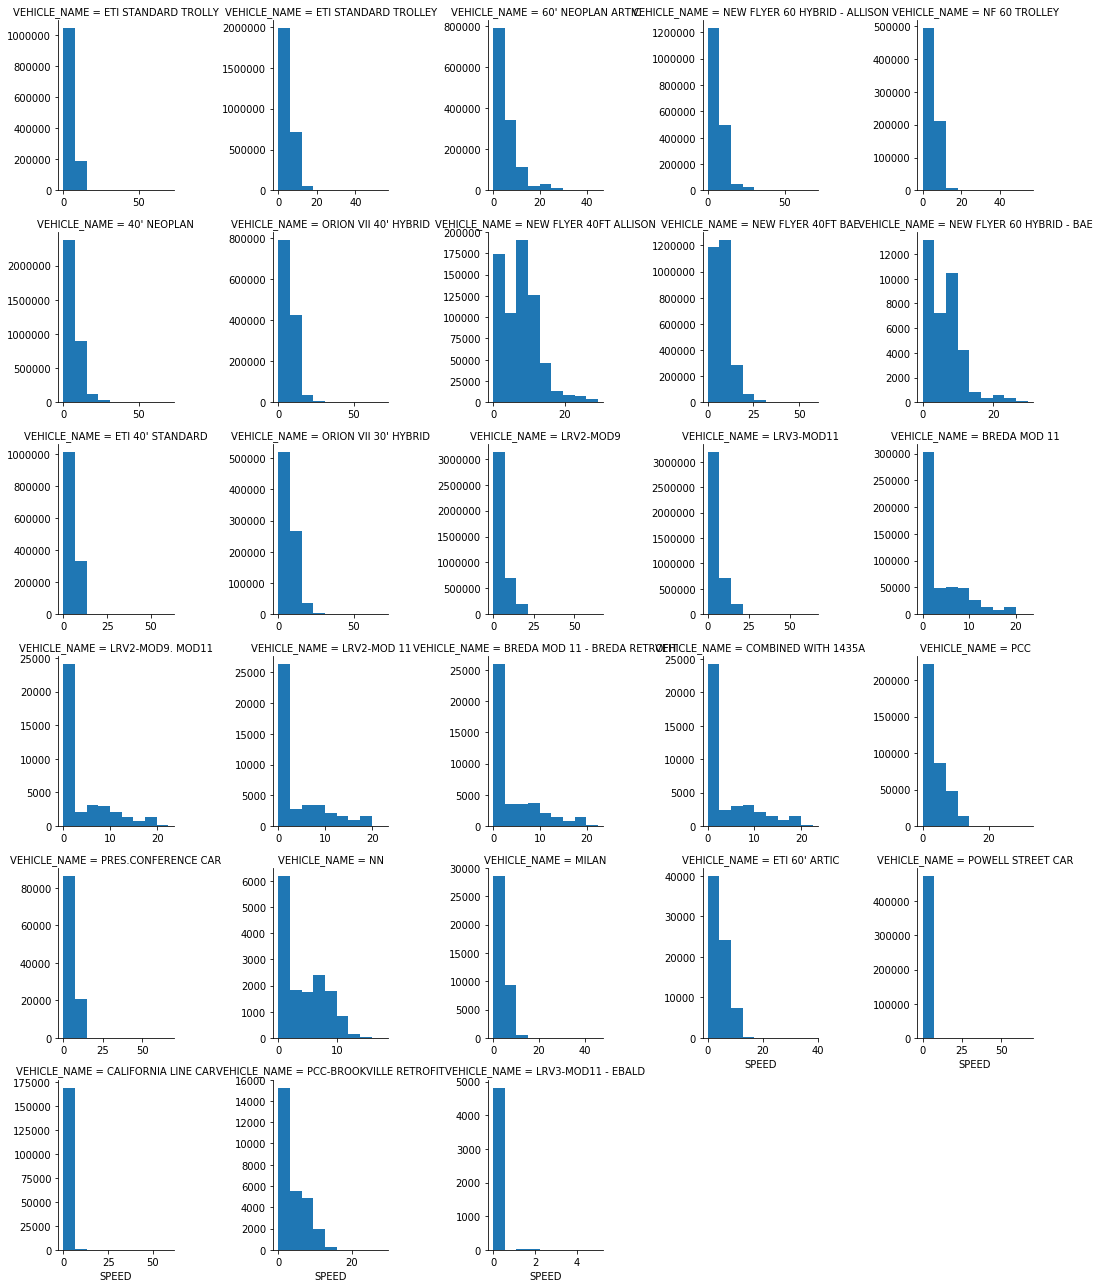

In [45]:
plt.figure(4)
g = sns.FacetGrid(main_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
g.savefig('../../output/all_region_speed_by_vehicle_type.pdf')
plt.show()

Find Vehicles with questionable speeds (mostly in 0 range).
If they are mostly 0 speed and also few in count, consider removing them from the data as it will severely skew the average speed of each region.